**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1EcHhwOCIhvm4mpxEbDGRawIJ4BpbAyqO?usp=sharing)

3. Практический ноутбук 2

3. [Практический ноутбук 3](https://colab.research.google.com/drive/1tSOXY1AZ4-JrzlILL8bceAo2Syr3dJ2i?usp=sharing)


Мы продолжаем работу с базой "Стройка". В данном ноутбуке построим модель архитектуры **U-Net** в различных вариациях. Решать задачу будем для полной базы на **16** классов.

Вначале повторим шаги из первого практического ноутбука с загрузкой библиотек и формированием выборок:

## Подключение бибилиотек


In [ ]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model 

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Дополнительные утилиты keras
from tensorflow.keras import utils 

# Инструменты для построения графиков
import matplotlib.pyplot as plt 

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Инструменты для работы с массивами
import numpy as np 

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image 

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

## Загрузка датасета

Возьмем для работы базу "Стройка" с разрешением изображений **256х192**.

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:11<00:00, 19.3MB/s]


'construction_256x192.zip'

In [ ]:
# Распаковка архива

!unzip -qo construction_256x192.zip

In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки 
IMG_HEIGHT = 256              # Высота картинки 
CLASS_COUNT = 16              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.36 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100


In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.34 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100


In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

## Создание выборки

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(1900, 192, 256, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(100, 192, 256, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


## Функция визуализации результатов сегментации

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)
    
    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

## Архитектура U-net


**U-Net** - сверточная нейронная сеть, разработанная Олафом Роннебергером, Филиппом Фишером, Томасом Броксом для выполнения семантической сегментации биомедицинских изображений в 2015 году и описанная в статье «U-Net: сверточные сети для сегментации биомедицинских изображений». 

Архитектура **U-Net** оптимизирована для обеспечения наилучшей сегментации с меньшим количеством обучающих данных. Она построена без полносвязных слоев и относится к типу полностью сверточных сетей (**FCNN**). 

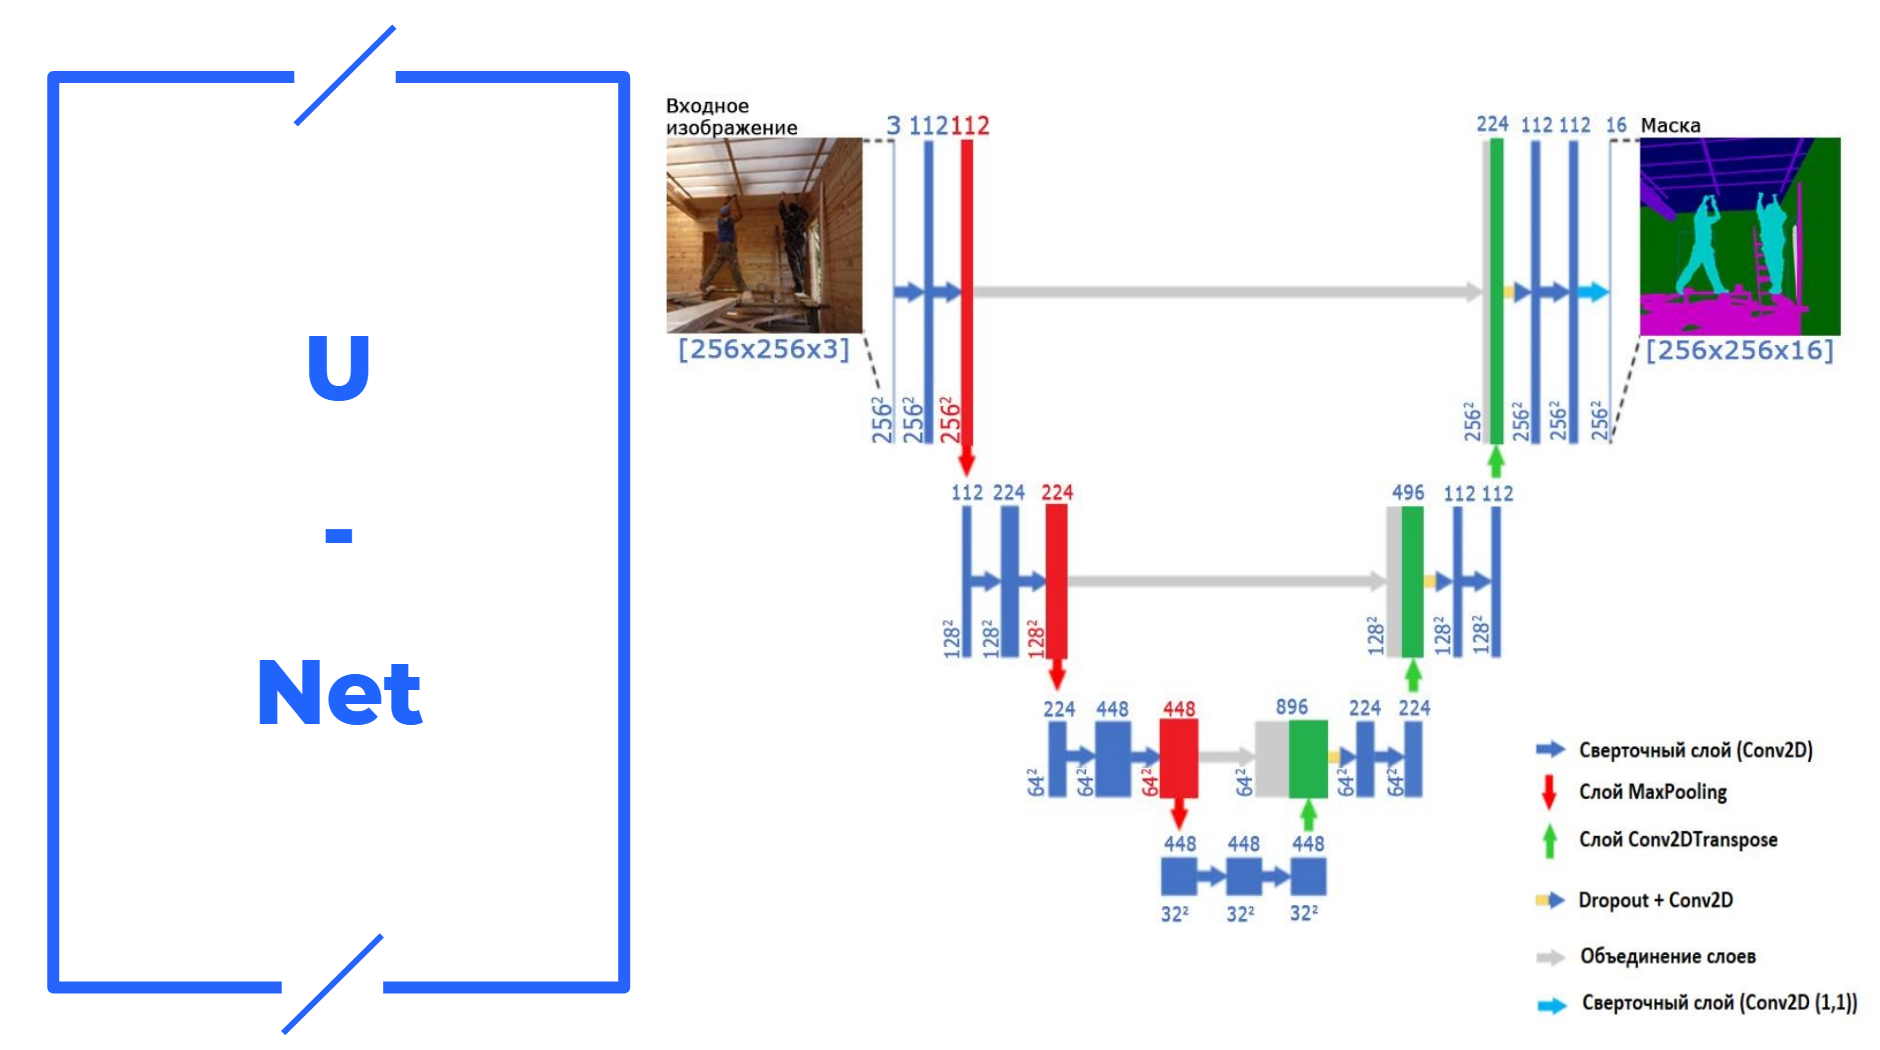

Архитектура **U-Net** представляет собой U-образную сеть, состоящую из трех частей: 
> 1. Путь сужения / понижения дискретизации;
2. Узкое место - "бутылочное горлышко";
3. Путь расширения / увеличения дискретизации.


Путь понижения дискретизации:
> Состоит из двух сверточных слоев с ядром **3 × 3**, за каждой из которых следует активационный слой **ReLU** и слой **MaxPooling2D** c ядром **2 × 2** и с шагом **2** для понижения дискретизации.
На каждом этапе понижения количество каналов удваивается.


Путь расширения дискретизации:
> Каждый шаг пути расширения состоит из слоя «повышающей свертки» **2 × 2** (**Conv2DTranspose**), объединения с соответствующей картой признаков из пути понижения дискретизации и двух сверток **3 × 3** с активацией **ReLU**.

Латеральные соединения:
>Латеральные (боковые) соединения из пути понижения дискретизации объединяются с картой признаков по пути повышения дискретизации. Эти пробросы приносят глобальную информацию, извлекаемую в разных слоях понижения дискретизации, в соответствующие по форме данных слои на пути повышения дискретизации.

Последний слой:
>На последнем слое сети используется свертка **1 × 1** для сопоставления каждого вектора признаков с требуемым количеством классов.

В итоге для **U-Net** характерно:

- достижение высоких результатов в различных реальных сценариях;
- обработка небольшого количества данных для достижения хороших результатов. 

В режиме распознавания модель работает быстро. Сегментация изображения **512×512** занимает менее секунды на современном графическом процессоре.

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ): 
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_unet = unet(CLASS_COUNT, 
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [ ]:
# Обучение модели

history = model_unet.fit(x_train, y_train, 
                         epochs=50, batch_size=32,
                         validation_data=(x_val, y_val)) 

Epoch 1/50
60/60 [==============================] - 50s 618ms/step - loss: 1.4600 - sparse_categorical_accuracy: 0.5333 - val_loss: 52.7668 - val_sparse_categorical_accuracy: 0.4303
Epoch 2/50
60/60 [==============================] - 35s 581ms/step - loss: 1.0618 - sparse_categorical_accuracy: 0.6664 - val_loss: 1.8666 - val_sparse_categorical_accuracy: 0.3793
Epoch 3/50
60/60 [==============================] - 35s 581ms/step - loss: 0.9619 - sparse_categorical_accuracy: 0.6968 - val_loss: 1.7586 - val_sparse_categorical_accuracy: 0.4231
Epoch 4/50
60/60 [==============================] - 35s 580ms/step - loss: 0.8815 - sparse_categorical_accuracy: 0.7216 - val_loss: 2.0214 - val_sparse_categorical_accuracy: 0.3378
Epoch 5/50
60/60 [==============================] - 35s 581ms/step - loss: 0.8462 - sparse_categorical_accuracy: 0.7325 - val_loss: 1.7906 - val_sparse_categorical_accuracy: 0.4163
Epoch 6/50
60/60 [==============================] - 35s 581ms/step - loss: 0.8104 - sparse_cat

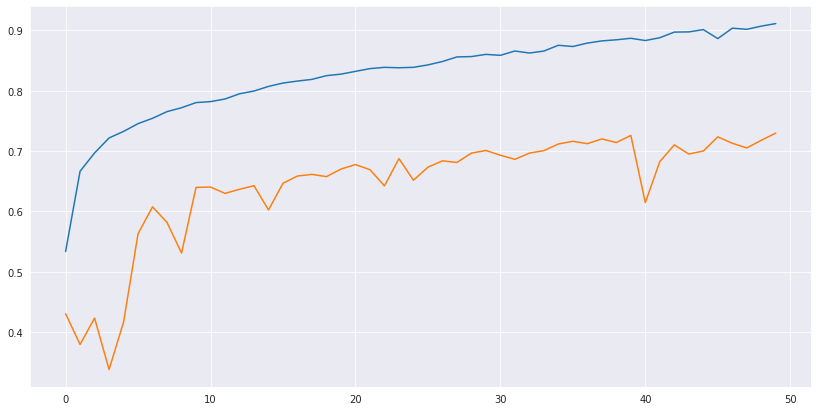

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

График обучения позволяет заключить, что имеет смысл продолжить обучение модели, поскольку рост точности продолжается. Можно наблюдать это более отчетливо, если вывести график последних **30** эпох:

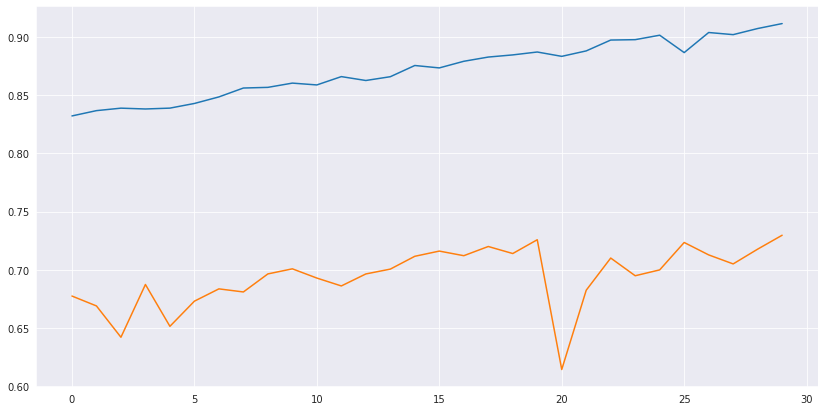

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'][-30:])
plt.plot(history.history['val_sparse_categorical_accuracy'][-30:])
plt.show()

Дообучим модель еще на **50** эпохах:

In [ ]:
# Обучение модели

history = model_unet.fit(x_train, 
                         y_train, 
                         epochs=50, 
                         batch_size=32,
                         validation_data=(x_val, y_val)) 

Epoch 1/50
60/60 [==============================] - 35s 582ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.9627 - val_sparse_categorical_accuracy: 0.7325
Epoch 2/50
60/60 [==============================] - 35s 580ms/step - loss: 0.2716 - sparse_categorical_accuracy: 0.9107 - val_loss: 1.0951 - val_sparse_categorical_accuracy: 0.7137
Epoch 3/50
60/60 [==============================] - 35s 580ms/step - loss: 0.2512 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.9394 - val_sparse_categorical_accuracy: 0.7240
Epoch 4/50
60/60 [==============================] - 35s 580ms/step - loss: 0.2466 - sparse_categorical_accuracy: 0.9188 - val_loss: 0.9603 - val_sparse_categorical_accuracy: 0.7322
Epoch 5/50
60/60 [==============================] - 35s 580ms/step - loss: 0.2444 - sparse_categorical_accuracy: 0.9191 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.7238
Epoch 6/50
60/60 [==============================] - 35s 580ms/step - loss: 0.2293 - sparse_cate

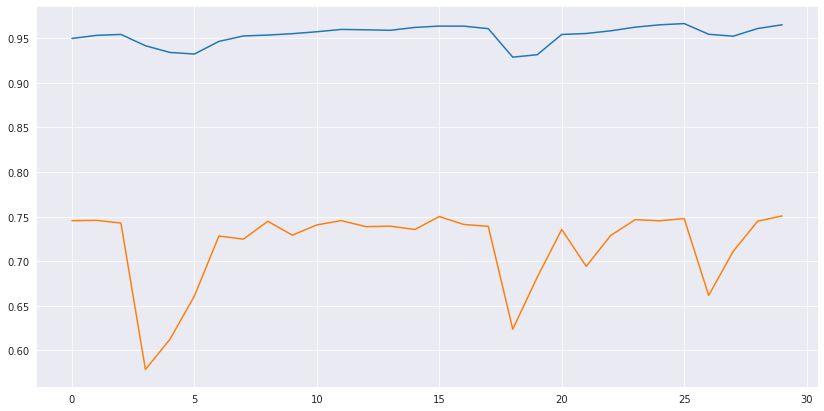

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'][-30:])
plt.plot(history.history['val_sparse_categorical_accuracy'][-30:])
plt.show()

**Распознавание**

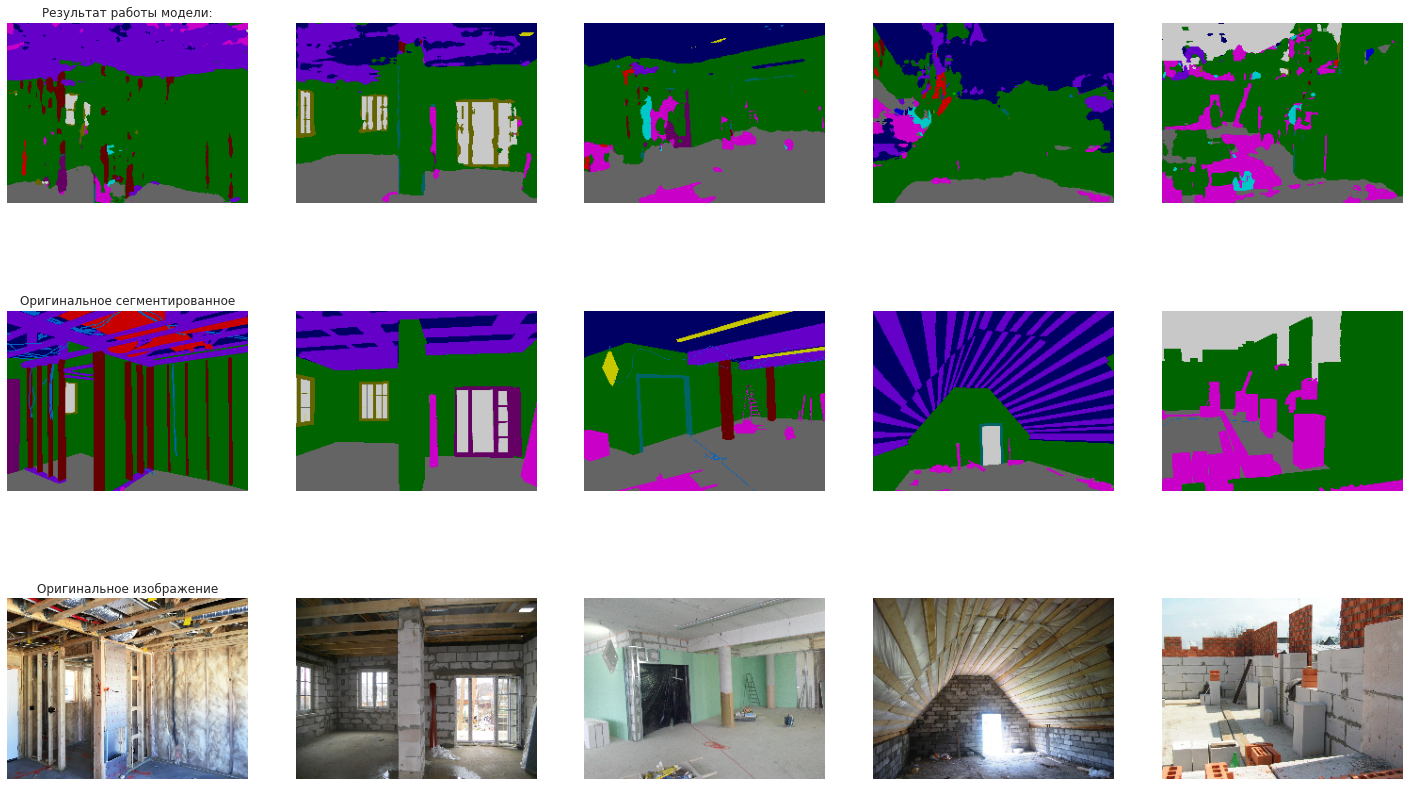

In [ ]:
# Отображение результатов работы модели

process_images(model_unet, 5)

Мы получили не самый плохой результат. Стандартная модель **U-Net** способна находить контуры и позиции объектов. А в некоторых случаях даже довольно точно обнаруживать элементы.

Проведем дополнительные эксперименты с архитектурой **U-Net**.

## Упрощённая архитектура U-net


Упростим архитектуру и проверим, насколько хуже она работает.

В упрощенной архитектуре не используется слой `BatchNormalization()` по скольку он требует достаточно большие вычислительные мощности. Также, количество уровней и пробросов в сети сокращается всего до двух. Чтобы эффективно сжимать и расжимать картинку при всего двух слоях `MaxPooling()` и `Conv2DTranspose()`, мы укажем, что каждый слой меняет размерность не в 2 раза, а в 4.

In [ ]:
def simple_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 32-нейронами
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D(4)(block_1_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D(4)(block_2_out)                                         # Добавляем слой MaxPooling2D чтобы сжать картинку в 4 раза
    
    # UP 1
    x = Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 64-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 64-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(x)      # Добавляем Conv2DTranspose-слой с 32-нейронами и размером ядра + шага равным 4
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x)                               # Добавляем Conv2D-слой с 32-нейронами
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count,(3,3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание упрощенной модели и вывод сводки

model_simple_unet = simple_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT, 3))  
  
model_simple_unet.summary()                                                          

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 32)      896       
                                                                 
 activation_19 (Activation)  (None, 192, 256, 32)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 256, 32)      9248      
                                                                 
 activation_20 (Activation)  (None, 192, 256, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 64, 32)       0         
 2D)                                                             
                                                           

In [ ]:
# Обучение модели

history = model_simple_unet.fit(x_train, y_train,
                                epochs=100, batch_size=32,
                                validation_data=(x_val, y_val)) 

Epoch 1/100
60/60 [==============================] - 8s 111ms/step - loss: 1.8447 - sparse_categorical_accuracy: 0.4866 - val_loss: 1.9532 - val_sparse_categorical_accuracy: 0.4597
Epoch 2/100
60/60 [==============================] - 6s 101ms/step - loss: 1.6084 - sparse_categorical_accuracy: 0.5170 - val_loss: 1.8055 - val_sparse_categorical_accuracy: 0.4876
Epoch 3/100
60/60 [==============================] - 6s 101ms/step - loss: 1.4102 - sparse_categorical_accuracy: 0.5674 - val_loss: 1.6362 - val_sparse_categorical_accuracy: 0.5190
Epoch 4/100
60/60 [==============================] - 6s 101ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.5280 - val_sparse_categorical_accuracy: 0.5481
Epoch 5/100
60/60 [==============================] - 6s 101ms/step - loss: 1.1202 - sparse_categorical_accuracy: 0.6502 - val_loss: 1.5415 - val_sparse_categorical_accuracy: 0.5542
Epoch 6/100
60/60 [==============================] - 6s 101ms/step - loss: 1.0477 - sparse_cate

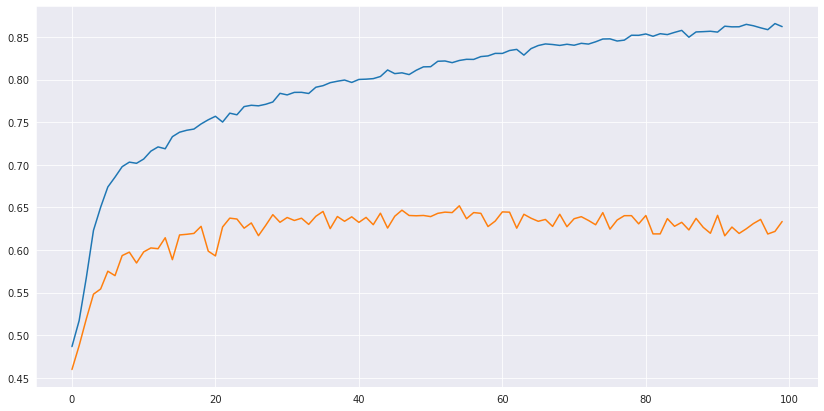

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

**Распознавание**

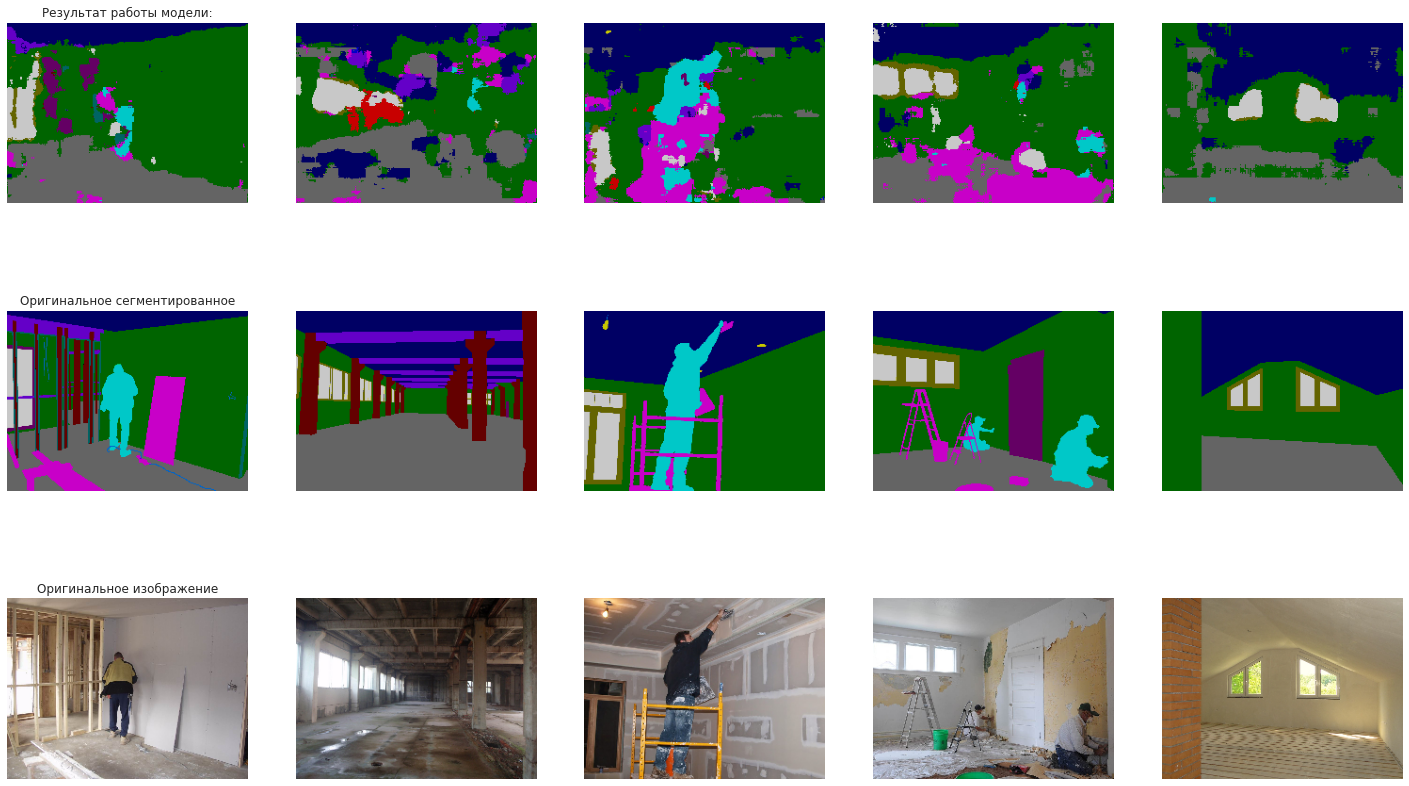

In [ ]:
process_images(model_simple_unet, 5)

Модель обучилась довольно быстро, но результаты заметно хуже первой версии.

Попробуем теперь усложнить архитектуру:

## Расширенная архитектура U-net


In [ ]:
def masked_unet(class_count,  # количество классов
                input_shape   # форма входного изображения
                ):
  
    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)              # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)          # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out)                                             # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)             # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                             # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)             # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                             # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                         # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out)         # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)             # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                                   # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                         # Объединяем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                         # Объединяем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)         # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                         # Объединяем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                                  # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)          # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                         # Объединяем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                                   # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'
    
    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание расширенной модели и вывод сводки

model_masked_unet = masked_unet(CLASS_COUNT,
                                (IMG_WIDTH, IMG_HEIGHT,3))

model_masked_unet.summary()  

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 192, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [ ]:
# Обучение модели

history = model_masked_unet.fit(x_train, y_train,
                                epochs=50, batch_size=16,
                                validation_data=(x_val, y_val)) 

Epoch 1/50
119/119 [==============================] - 54s 413ms/step - loss: 1.4090 - sparse_categorical_accuracy: 0.5467 - val_loss: 3.5099 - val_sparse_categorical_accuracy: 0.2150
Epoch 2/50
119/119 [==============================] - 47s 394ms/step - loss: 1.0529 - sparse_categorical_accuracy: 0.6651 - val_loss: 2.2603 - val_sparse_categorical_accuracy: 0.4232
Epoch 3/50
119/119 [==============================] - 47s 394ms/step - loss: 0.9331 - sparse_categorical_accuracy: 0.7091 - val_loss: 1.8273 - val_sparse_categorical_accuracy: 0.4315
Epoch 4/50
119/119 [==============================] - 47s 394ms/step - loss: 0.8783 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.3600 - val_sparse_categorical_accuracy: 0.5913
Epoch 5/50
119/119 [==============================] - 47s 394ms/step - loss: 0.8367 - sparse_categorical_accuracy: 0.7385 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.6128
Epoch 6/50
119/119 [==============================] - 47s 394ms/step - loss: 0.8077 -

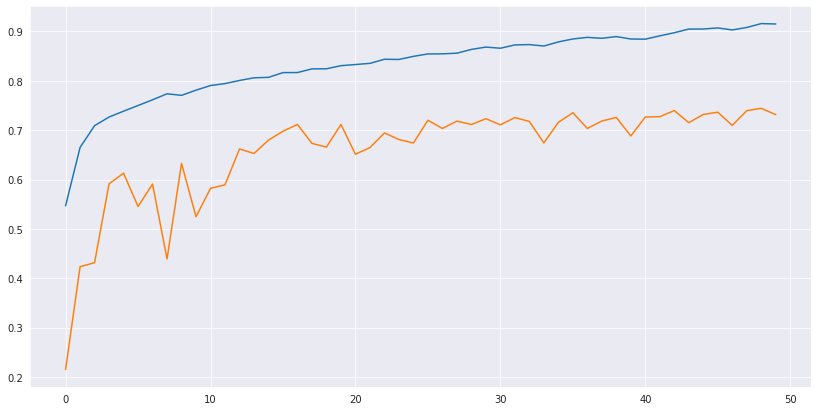

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

**Распознавание**

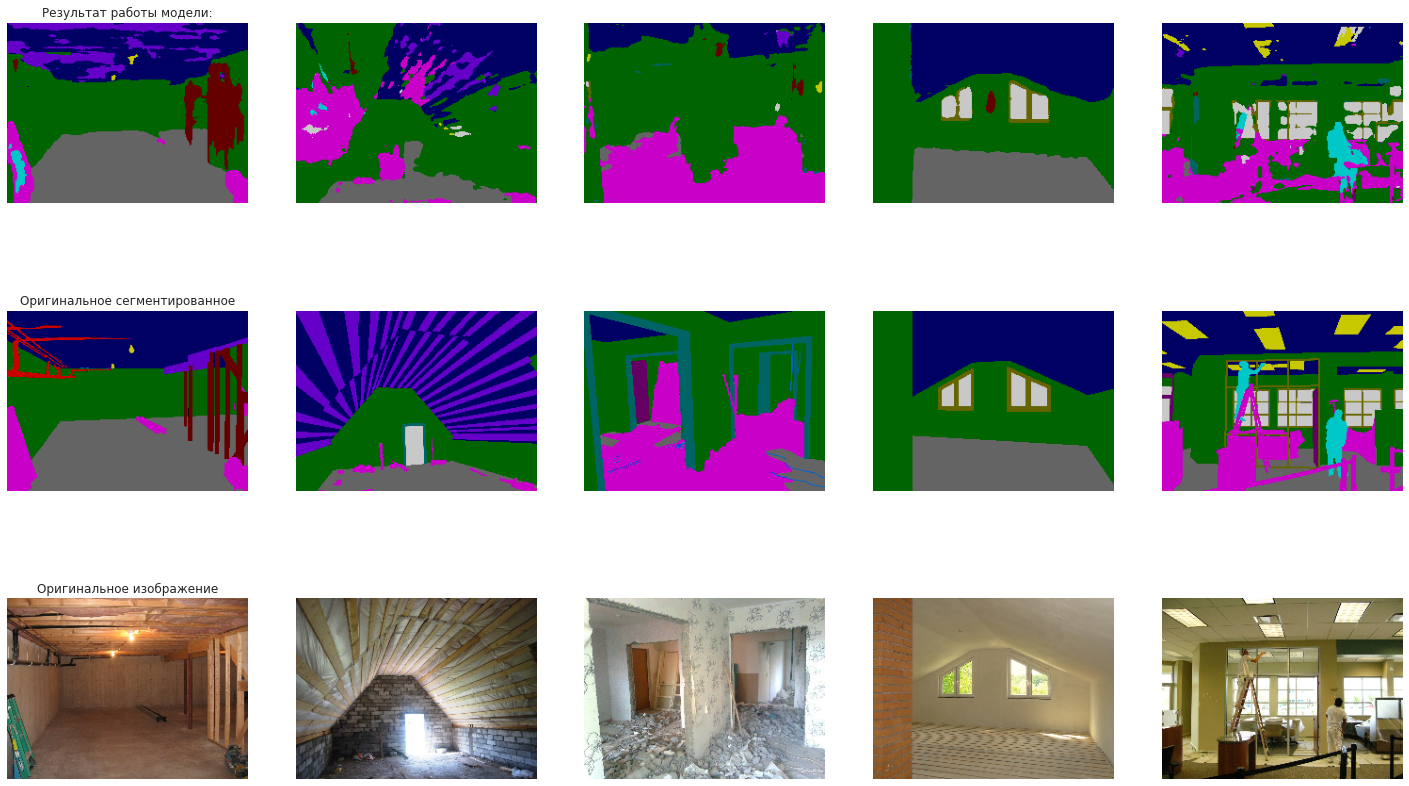

In [ ]:
# Отображение результатов работы модели

process_images(model_masked_unet, 5)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. [Практический ноутбук 1](https://colab.research.google.com/drive/1EcHhwOCIhvm4mpxEbDGRawIJ4BpbAyqO?usp=sharing)

3. Практический ноутбук 2

3. [Практический ноутбук 3](https://colab.research.google.com/drive/1tSOXY1AZ4-JrzlILL8bceAo2Syr3dJ2i?usp=sharing)
